<a href="https://colab.research.google.com/github/deeshlby/AAI_590_Group_9_Capstone/blob/angel-branch/LSTM_A1C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1 Importing Necessary Libraries and Modules

Preprocessing Libraries and file management

In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
!pip install PyWavelets
import pywt  # To Import PyWavelets for Haar Wavelet Decomposition
from scipy.interpolate import interp1d
from scipy.signal import spectrogram

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.3 MB/s eta 0:00:00


Deep Learning Framework

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input

Visualization Library

In [3]:
import matplotlib.pyplot as plt

## 1.2 Initialize Scaler and Define File Paths

In [4]:
# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Mount Google Drive
drive.mount('/content/drive')

# Path in Colab
training_folder = '/content/drive/MyDrive/glucosedataset/TrainingSubjects'

Mounted at /content/drive


## 2.1 Training Data Processing and Feature Engineering


- Load subject data from the training folder.
- Filter data for the last 3 months (to represent A1C).


In [5]:
print("Processing training data...")

# Getting a list of all the files in the training folder
training_files = os.listdir(training_folder)

# Creating empty lists to hold the processed data and target values
training_data = []
y_train = []


Processing training data...


## 2.2 Extract Features for Each Subject

* Normalize glucose values using MinMaxScaler.
* Generate sine and cosine waves based on timestamps.
* Extract rolling statistics (mean, std, median).
* Compute the top 5 FFT components.
* Calculate time spent in hypo, normal, and hyperglycemia ranges.

In [6]:
# Spectrogram = Define a fixed size for spectrograms
fixed_spectrogram_shape = (73, 144)  # To define the shape (frequencies, time bins)

# Processing training data for feature extraction
print("Processing training data...")

# File mgmnt. Get a list of all the files in the training folder
training_files = os.listdir(training_folder)

# List to manage data. Need to create empty lists to hold the processed data and target values
training_data = []
spectrogram_data = []
y_train = []

# Looping through each file in the folder (one file per subject)
for file in training_files:
    # Buildind the full file path
    file_path = os.path.join(training_folder, file)

    # to read the data for this subject
    subject_data = pd.read_csv(file_path)

    # Need to make sure the 'Timestamp' column is recognized as dates
    subject_data['Timestamp'] = pd.to_datetime(subject_data['Timestamp'])

    # To keep only the data from the last 3 months (To represent A1C)
    last_timestamp = subject_data['Timestamp'].max()
    three_months_ago = last_timestamp - pd.DateOffset(months=3)
    subject_data = subject_data[subject_data['Timestamp'] >= three_months_ago]

    # Scaling the glucose values to a 0-1 range
    glucose = scaler.fit_transform(subject_data['Glucose'].values.reshape(-1, 1)).flatten()

    # Generating spectrogram for the glucose data
    frequencies, times, spec = spectrogram(glucose, fs=1, nperseg=144)  # Spectrogram with glucose data

    # Standardizing spectrogram shape (pad or crop)
    if spec.shape != fixed_spectrogram_shape:
        padded_spec = np.zeros(fixed_spectrogram_shape)
        min_rows = min(fixed_spectrogram_shape[0], spec.shape[0])
        min_cols = min(fixed_spectrogram_shape[1], spec.shape[1])
        padded_spec[:min_rows, :min_cols] = spec[:min_rows, :min_cols]  # Pad or crop
        spec = padded_spec

    # Need to normalize spectrogram values
    spec_normalized = spec / np.max(np.abs(spec))  # Normalize to range [0, 1]

    # Then append normalized spectrogram
    spectrogram_data.append(spec_normalized)

    # Glucose derived metrics = features (rolling stats, wavelets, etc.)
    rolling_mean = pd.Series(glucose).rolling(window=30, min_periods=1).mean().fillna(0)
    rolling_std = pd.Series(glucose).rolling(window=30, min_periods=1).std().fillna(0)
    rolling_median = pd.Series(glucose).rolling(window=30, min_periods=1).median().fillna(0)

    # FFT components to represent signal frequencies and their amplitudes
    fft_vals = np.abs(np.fft.fft(glucose))[:5]

    # Haar Wavelet Decomposition
    coeffs = pywt.wavedec(glucose, 'haar', level=2)  # Decompose into levels
    haar_approx = coeffs[0]  # Approximation coefficients
    haar_details = np.concatenate(coeffs[1:])  # Concatenate all detail coefficients

    # Interpolate Haar coefficients to match glucose length (low-frequency/ "low pass filter")
    x_original_haar_approx = np.linspace(0, len(glucose) - 1, len(haar_approx))
    haar_approx_interpolated = np.interp(np.arange(len(glucose)), x_original_haar_approx, haar_approx)

    # Interpolate Haar coefficients to match glucose length (high-frequency/ "high pass filter")
    x_original_haar_details = np.linspace(0, len(glucose) - 1, len(haar_details))
    haar_details_interpolated = np.interp(np.arange(len(glucose)), x_original_haar_details, haar_details)

    # Normalize Haar coefficients to avoid seeing peaks out of range (outliers)
    haar_approx_normalized = np.divide(
        haar_approx_interpolated,
        np.max(np.abs(haar_approx_interpolated)),
        out=np.zeros_like(haar_approx_interpolated),
        where=np.max(np.abs(haar_approx_interpolated)) > 0
    )

    haar_details_normalized = np.divide(
        haar_details_interpolated,
        np.max(np.abs(haar_details_interpolated)),
        out=np.zeros_like(haar_details_interpolated),
        where=np.max(np.abs(haar_details_interpolated)) > 0
    )


    # Sine and cosine waves to model cyclic patterns
    wave_frequency = 2 * np.pi / len(glucose)
    sine_wave = np.sin(np.arange(len(glucose)) * wave_frequency)
    cosine_wave = np.cos(np.arange(len(glucose)) * wave_frequency)
    sine_wave_normalized = (sine_wave - np.min(sine_wave)) / (np.max(sine_wave) - np.min(sine_wave))
    cosine_wave_normalized = (cosine_wave - np.min(cosine_wave)) / (np.max(cosine_wave) - np.min(cosine_wave))

    # Time spent in hypo, hyper, and normal ranges
    hypo_time = (subject_data['Glucose'] < 70).sum() / len(subject_data['Glucose'])
    hyper_time = (subject_data['Glucose'] > 180).sum() / len(subject_data['Glucose'])
    normal_time = 1 - hypo_time - hyper_time

    # Combine all the features together
    combined_features = np.column_stack((
        glucose,
        rolling_mean,
        rolling_std,
        rolling_median,
        np.pad(fft_vals, (0, len(glucose) - len(fft_vals)), 'constant'),
        haar_approx_normalized,
        haar_details_normalized,
        sine_wave_normalized,
        cosine_wave_normalized,
        np.full(len(glucose), hypo_time),
        np.full(len(glucose), normal_time),
        np.full(len(glucose), hyper_time)
    ))

    # Save features and target
    training_data.append(combined_features)
    y_train.append(subject_data['Hemoglobin A1C'].iloc[0])  # A1C is the target

Processing training data...


## Combine and Save Processed Data
* Merge all subject features and targets into a single dataset.
* Print the shape of the resulting dataset.

In [7]:
# Combine all the subjects' data into one big array
X_train = np.concatenate(training_data, axis=0)

# Convert spectrograms and target values into arrays
spectrogram_data = np.array(spectrogram_data)
y_train = np.array(y_train)

# Print some info about the processed data
print(f"Processed {len(training_files)} subjects.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Spectrogram data shape: {spectrogram_data.shape}")

Processed 43 subjects.
X_train shape: (1076515, 12), y_train shape: (43,)
Spectrogram data shape: (43, 73, 144)


## 2.4 Plot Features for a Sample Subject
* Visualize normalized glucose values, rolling statistics, and wave features for one subject.
* Confirm that the features are calculated correctly.

In [8]:
# After processing, I will plot features for a sample subject. This subject is used to represent A1C.
sample_subject = training_data[0]  # Choosing only one subject for visualization

# Calculate three_months_ago and generate timestamps
# Filter data for the last 3 months
last_timestamp = subject_data['Timestamp'].max()  # Get the most recent timestamp in the data
three_months_ago = last_timestamp - pd.DateOffset(months=3)  # Calculate the cutoff date
filtered_data = subject_data[subject_data['Timestamp'] >= three_months_ago]  # Filter the data

# Match the length of sample_subject with filtered_data
sample_subject = sample_subject[:len(filtered_data)]

# Use the real timestamps from the filtered data
timestamps = filtered_data['Timestamp']

# Extract features for plotting
glucose_values = sample_subject[:, 0]          # Normalized glucose
rolling_mean = sample_subject[:, 1]            # Rolling mean
rolling_std = sample_subject[:, 2]             # Rolling standard deviation
rolling_median = sample_subject[:, 3]          # Rolling median
haar_approx = sample_subject[:, 4]             # Haar wavelet approximation coefficients
haar_details = sample_subject[:, 5]            # Haar wavelet detail coefficients
sine_wave = sample_subject[:, -4]              # Sine wave (4th last column)
cosine_wave = sample_subject[:, -3]            # Cosine wave (3rd last column)

# Select spectrogram data for the same subject
subject_spectrogram = spectrogram_data[0]  # First subject's spectrogram

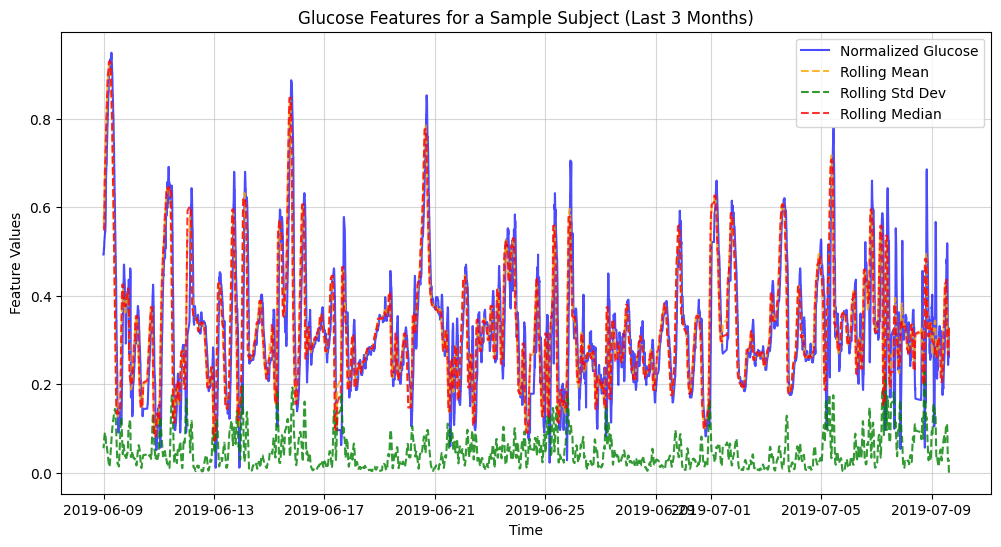

In [9]:
# Plot for glucose features
plt.figure(figsize=(12, 6))
plt.plot(timestamps, glucose_values, label='Normalized Glucose', color='blue', alpha=0.7)
plt.plot(timestamps, rolling_mean, label='Rolling Mean', color='orange', linestyle='--', alpha=0.8)
plt.plot(timestamps, rolling_std, label='Rolling Std Dev', color='green', linestyle='--', alpha=0.8)
plt.plot(timestamps, rolling_median, label='Rolling Median', color='red', linestyle='--', alpha=0.8)
plt.title("Glucose Features for a Sample Subject (Last 3 Months)")
plt.xlabel("Time")
plt.ylabel("Feature Values")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

This plot shows an overview of glucose trends and variability for a single subject over the past three months (chosen above as last timestamp - 3 months offset). The **blue line** represents the normalized glucose values, showing daily fluctuations and indicating periods of high and low glucose levels. The **orange dashed line** is the rolling mean, which smooths out the fluctuations to reveal the general trend in glucose levels over time. The **green dashed line**, shows the rolling standard deviation, which highlights variability, with larger spikes pointing to periods of greater instability or sudden changes in glucose levels. The **red dashed line**, the rolling median, provides an additional measure of central tendency, capturing where most of the data is concentrated. This measure that used for features shows a comprehensive understanding of glucose behavior, which can help pattern detection in the LSTM model.

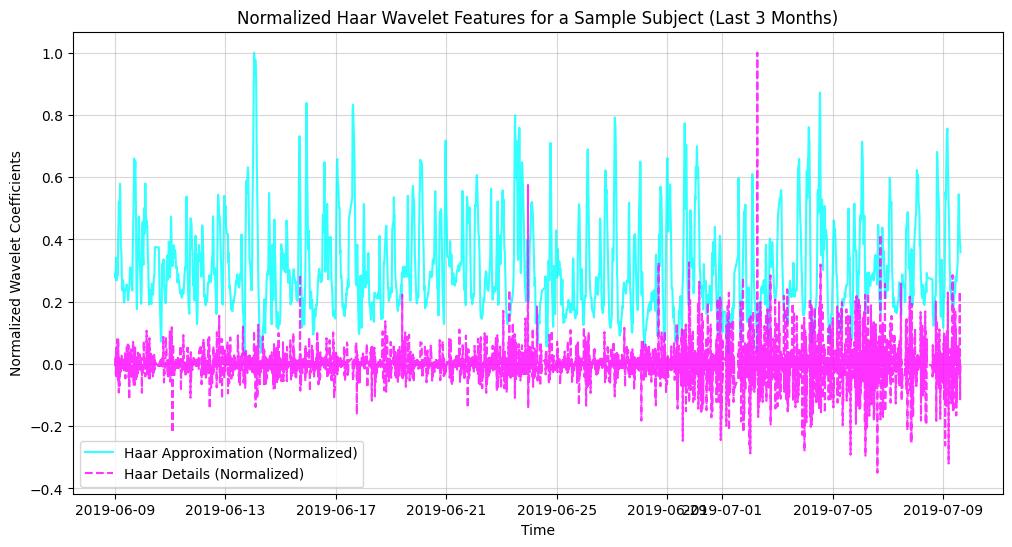

In [10]:
# Plot for Haar wavelet features
plt.figure(figsize=(12, 6))
plt.plot(timestamps, haar_approx_normalized, label='Haar Approximation (Normalized)', color='cyan', linestyle='-', alpha=0.8)
plt.plot(timestamps, haar_details_normalized, label='Haar Details (Normalized)', color='magenta', linestyle='--', alpha=0.8)
plt.title("Normalized Haar Wavelet Features for a Sample Subject (Last 3 Months)")
plt.xlabel("Time")
plt.ylabel("Normalized Wavelet Coefficients")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


This plot shows the **Haar wavelet features** derived from the glucose data for a single subject over the past three months. The **cyan line** represents the normalized Haar approximation coefficients, which capture the trend or **low-frequency** components of the glucose signal. These approximations provide a smoothed version of the glucose data, highlighting the broader patterns and long-term trends. This aligns directly with A1C, as A1C reflects the average glucose exposure over weeks and months. The **magenta dashed line** represents the normalized Haar detail coefficients, which capture the **high-frequency** components or finer fluctuations in the signal. These details emphasize rapid changes or anomalies in glucose levels over time. Together, the Haar wavelet features provide a **multi-scale perspective** on the glucose signal, making them useful for detecting both long-term trends and short-term variations. This multi-scale analysis is critical for predictive analysis and feature engineering, as it incorporates the stable glucose patterns and dynamic changes that influence A1C.

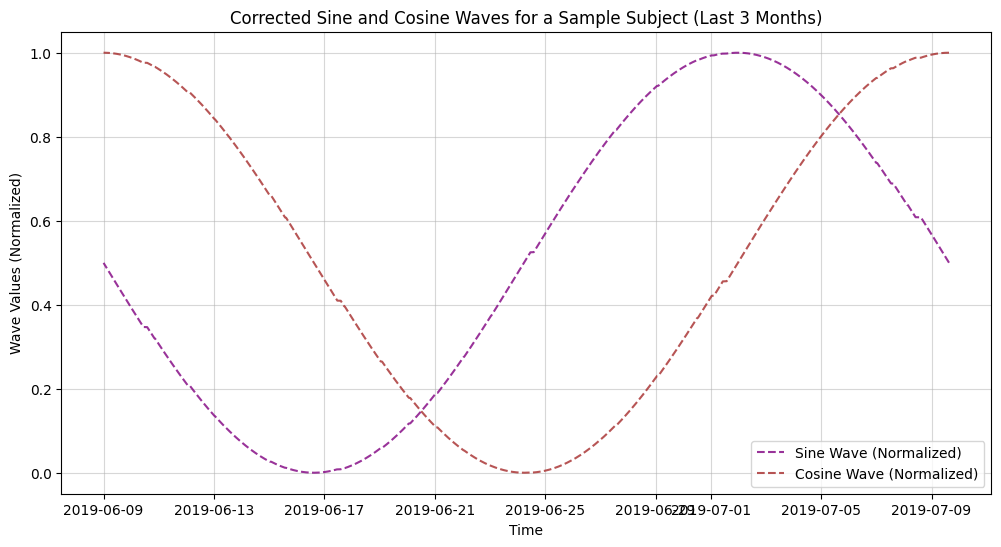

In [11]:
# Plotting sine and cosine waves
plt.figure(figsize=(12, 6))
plt.plot(timestamps, sine_wave_normalized, label='Sine Wave (Normalized)', color='purple', linestyle='--', alpha=0.8)
plt.plot(timestamps, cosine_wave_normalized, label='Cosine Wave (Normalized)', color='brown', linestyle='--', alpha=0.8)
plt.title("Corrected Sine and Cosine Waves for a Sample Subject (Last 3 Months)")
plt.xlabel("Time")
plt.ylabel("Wave Values (Normalized)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

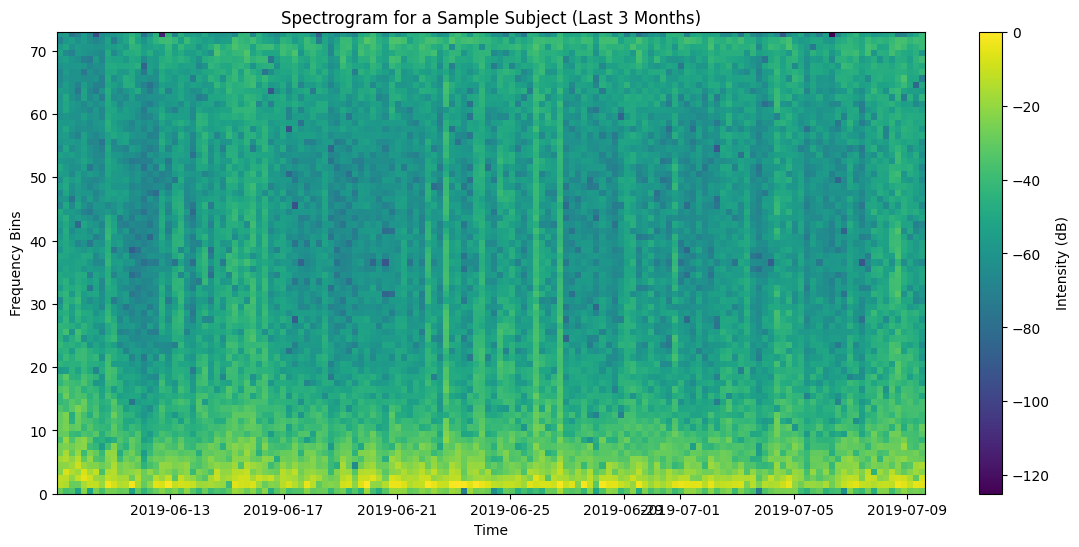

In [12]:
#Plot for spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(
    10 * np.log10(subject_spectrogram),  # Convert spectrogram to dB scale
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[timestamps.min(), timestamps.max(), 0, subject_spectrogram.shape[0]]
)
plt.colorbar(label='Intensity (dB)')
plt.title("Spectrogram for a Sample Subject (Last 3 Months)")
plt.xlabel("Time")
plt.ylabel("Frequency Bins")
plt.show()

# SMOTE Balancing and Model Training Pipeline

## 3.1 Binning the Target Variable for SMOTE

To apply SMOTE, we first binned the continuous `y_train` values into discrete categories. This step is necessary because **SMOTE requires discrete categories** to generate synthetic samples by interpolating within a class, which is not possible with continuous values. We used `np.linspace` to define bin edges based on the range of `y_train` and then assigned each `y_train` value to its corresponding bin using `np.digitize`. This ensures that the target variable is suitable for oversampling while preserving meaningful groupings of the A1C values.

In [13]:
# Ensure y_train is a NumPy array
y_train_array = np.array(y_train)

# Define bins
num_bins = 15  # for granularity
bin_edges = np.linspace(y_train_array.min(), y_train_array.max(), num_bins + 1)

# Assign bins
y_train_bins = np.digitize(y_train_array, bins=bin_edges, right=False)

# Calculate distribution
unique_bins, bin_counts = np.unique(y_train_bins, return_counts=True)

# Print distribution
print("Binned target distribution:")
for bin_num, count in zip(unique_bins, bin_counts):
    bin_range = f"{bin_edges[bin_num - 1]:.2f} - {bin_edges[bin_num]:.2f}" if bin_num < len(bin_edges) else "Overflow"
    print(f"Bin {bin_num}: {count} samples (Range: {bin_range})")

Binned target distribution:
Bin 1: 2 samples (Range: 6.30 - 6.55)
Bin 2: 2 samples (Range: 6.55 - 6.79)
Bin 3: 6 samples (Range: 6.79 - 7.04)
Bin 4: 3 samples (Range: 7.04 - 7.29)
Bin 5: 4 samples (Range: 7.29 - 7.53)
Bin 6: 6 samples (Range: 7.53 - 7.78)
Bin 7: 4 samples (Range: 7.78 - 8.03)
Bin 8: 5 samples (Range: 8.03 - 8.27)
Bin 9: 3 samples (Range: 8.27 - 8.52)
Bin 10: 2 samples (Range: 8.52 - 8.77)
Bin 11: 4 samples (Range: 8.77 - 9.01)
Bin 15: 1 samples (Range: 9.75 - 10.00)
Bin 16: 1 samples (Range: Overflow)


The bins distributions showed bins with very few samples. By merging the last two sparse bins (Bin 15 and Bin 16) into the previous bin (Bin 15). This ensures that all bins have a sufficient number of samples, making SMOTE more effective during the oversampling process. It will help preserve meaningful groupings for A1C prediction.

In [14]:
# merging sparse bins
y_train_bins = np.where(y_train_bins > 15, 15, y_train_bins)  # Combine bin 15 and bin 16 with Bin 15
# Recalculate distribution
unique_bins, bin_counts = np.unique(y_train_bins, return_counts=True)
print("Adjusted binned target distribution after merging bins:")
for bin_num, count in zip(unique_bins, bin_counts):
    bin_range = f"{bin_edges[bin_num - 1]:.2f} - {bin_edges[bin_num]:.2f}" if bin_num < len(bin_edges) else "Overflow"
    print(f"Bin {bin_num}: {count} samples (Range: {bin_range})")

Adjusted binned target distribution after merging bins:
Bin 1: 2 samples (Range: 6.30 - 6.55)
Bin 2: 2 samples (Range: 6.55 - 6.79)
Bin 3: 6 samples (Range: 6.79 - 7.04)
Bin 4: 3 samples (Range: 7.04 - 7.29)
Bin 5: 4 samples (Range: 7.29 - 7.53)
Bin 6: 6 samples (Range: 7.53 - 7.78)
Bin 7: 4 samples (Range: 7.78 - 8.03)
Bin 8: 5 samples (Range: 8.03 - 8.27)
Bin 9: 3 samples (Range: 8.27 - 8.52)
Bin 10: 2 samples (Range: 8.52 - 8.77)
Bin 11: 4 samples (Range: 8.77 - 9.01)
Bin 15: 2 samples (Range: 9.75 - 10.00)


## 3.2 Repeat Bins for Time-Series Data

To ensure that SMOTE applies balancing at the time-series level, each time-series entry in X_train must be associated with its corresponding subject’s A1C bin. This is achieved by repeating the A1C bin for all time-series entries within each subject’s dataset. Specifically, for every subject, a full array of the same bin value is created with the length (3 months) matching the number of time-series entries for that subject. These arrays are then concatenated to form y_train_bins_repeated, which aligns each time-series entry in X_train with its corresponding bin, ensuring proper balancing during the oversampling process.

In [15]:
# Ensure all time-series entries in X_train are associated with their subject's A1C bin
print("Repeating A1C bins for all time-series entries...")

# Repeat bins for each subject's time-series data
y_train_bins_repeated = np.concatenate([
    np.full(len(subject_data), y_bin) for subject_data, y_bin in zip(training_data, y_train_bins)
])

# Confirm the result by printing the shape and a sample of repeated bins
print(f"Shape of y_train_bins_repeated: {y_train_bins_repeated.shape}")

Repeating A1C bins for all time-series entries...
Shape of y_train_bins_repeated: (1076515,)


In [16]:
# Validate total count
assert len(y_train_bins_repeated) == sum(len(subject_data) for subject_data in training_data)

# Check bins for a specific subject
subject_index = 0
print(f"Bins for Subject {subject_index}: {np.unique(y_train_bins_repeated[:len(training_data[subject_index])])}")

Bins for Subject 0: [1]


In [17]:
subject_0_y_train = y_train[0]
print(f"Subject 0's y_train value: {subject_0_y_train}")

Subject 0's y_train value: 6.3


The shape of (1076515,) confirms that the bins are correctly repeated for all time-series entries in X_train.

Sample Values:

The output Bins for Subject 0: [1] confirms that all time-series entries for Subject 0 have been assigned to Bin 1. We expected this since Subject 0's y_train value was placed in Bin 1 during the binning process.

## 3.3 Flatten Features for SMOTE
* Need to convert X_train into a flat 2D array to make it compatible with SMOTE, which requires a row for each sample and columns for features.
* Flattening ensures that feature relationships within each sample are preserved while enabling SMOTE to effectively balance the target distribution.

In [18]:
# Flatten X_train for SMOTE
print("Flattening features for SMOTE...")
X_train_flattened = np.vstack(X_train)  # Stack all features into a 2D array

# Confirm the result
print(f"Shape of X_train_flattened: {X_train_flattened.shape}")
print("Sample rows from X_train_flattened:")
print(X_train_flattened[:5, :])  # Display the first 5 rows of the flattened array

Flattening features for SMOTE...
Shape of X_train_flattened: (1076515, 12)
Sample rows from X_train_flattened:
[[ 3.25779037e-01  3.25779037e-01  0.00000000e+00  3.25779037e-01
   1.41332011e+04  3.08524333e-01  6.58844282e-02  5.00000000e-01
   1.00000000e+00  1.59597777e-02  7.45197076e-01  2.38843147e-01]
 [ 3.22946176e-01  3.24362606e-01  2.00313536e-03  3.24362606e-01
   2.20392806e+02  2.98347784e-01  6.96763940e-03  5.00072455e-01
   9.99999995e-01  1.59597777e-02  7.45197076e-01  2.38843147e-01]
 [ 3.00283286e-01  3.16336166e-01  1.39741724e-02  3.22946176e-01
   6.33310027e+01  2.88171236e-01 -2.28066158e-02  5.00144911e-01
   9.99999979e-01  1.59597777e-02  7.45197076e-01  2.38843147e-01]
 [ 2.74787535e-01  3.05949008e-01  2.37014172e-02  3.11614731e-01
   2.60896149e+02  2.77994687e-01 -7.98280060e-02  5.00217366e-01
   9.99999953e-01  1.59597777e-02  7.45197076e-01  2.38843147e-01]
 [ 2.63456091e-01  2.97450425e-01  2.79722630e-02  3.00283286e-01
   2.40574027e+02  2.678181

Shape for X_train_flattened has 1,076,515 rows (samples) and 12 columns (features). Each row represents a time-series entry and its corresponding features like glucose, rolling stats, FFT, wavelets, and sine/cosine waves.

## 3.4 Apply SMOTE for Balancing
* Address class imbalance in the binned target values using SMOTE.
* Resample both features and bins.

In [19]:
# Apply SMOTE
print("Applying SMOTE to address imbalance...")
smote = SMOTE(random_state=42)

# Resample features and bins
X_train_resampled, y_train_bins_resampled = smote.fit_resample(X_train_flattened, y_train_bins_repeated)

# Confirm the result
print(f"Shape of X_train_resampled: {X_train_resampled.shape}")
print(f"Shape of y_train_bins_resampled: {y_train_bins_resampled.shape}")

Applying SMOTE to address imbalance...
Shape of X_train_resampled: (2189064, 12)
Shape of y_train_bins_resampled: (2189064,)


## 3.5 Map Resampled Bins Back to Continuous Values
* Convert the resampled bins into continuous A1C values using bin centers.

Mapping resampled bins back to continuous values...
Shape of y_train_resampled: (2189064,)
Sample of resampled target values from different bins:
Target Value: 6.42, Count: 182422
Target Value: 6.67, Count: 182422
Target Value: 6.92, Count: 182422
Target Value: 7.16, Count: 182422
Target Value: 7.41, Count: 182422
Target Value: 7.66, Count: 182422
Target Value: 7.90, Count: 182422
Target Value: 8.15, Count: 182422
Target Value: 8.40, Count: 182422
Target Value: 8.64, Count: 182422


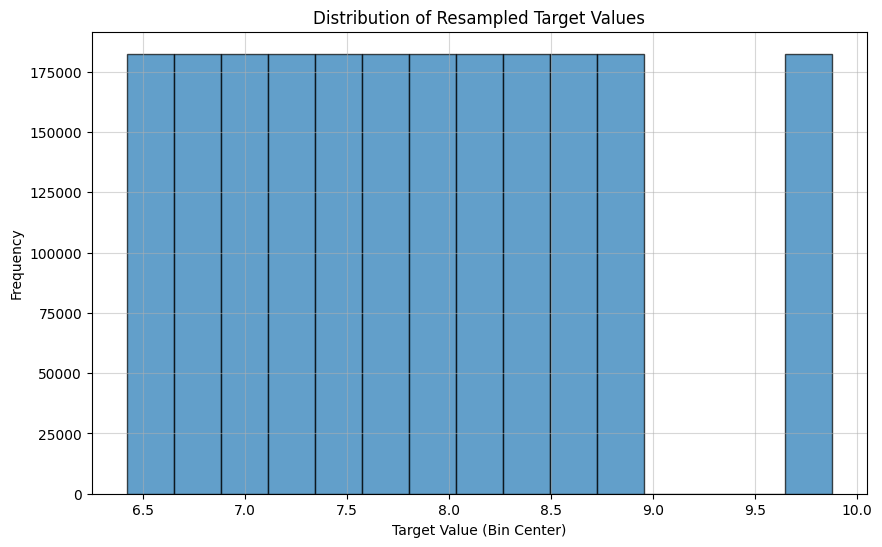

In [20]:
# Map the resampled bins back to continuous values
print("Mapping resampled bins back to continuous values...")
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate the center of each bin
y_train_resampled = bin_centers[y_train_bins_resampled - 1]  # Map bins to their centers

# Confirm the result with a diverse sample
print(f"Shape of y_train_resampled: {y_train_resampled.shape}")
print("Sample of resampled target values from different bins:")
unique_values, sample_counts = np.unique(y_train_resampled, return_counts=True)

# Display a few unique bin centers and their counts
for value, count in zip(unique_values[:10], sample_counts[:10]):  # Limit output for brevity
    print(f"Target Value: {value:.2f}, Count: {count}")

# Optionally show a histogram of resampled values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(y_train_resampled, bins=num_bins, edgecolor='k', alpha=0.7)
plt.title("Distribution of Resampled Target Values")
plt.xlabel("Target Value (Bin Center)")
plt.ylabel("Frequency")
plt.grid(alpha=0.5)
plt.show()

The histogram confirms a well-balanced distribution of resampled target values across all bins. This ensures uniform representation for improved model training.

## 3.6 Reshape Resampled Features
* Reshape X_train back into its original dimensionality after SMOTE.

In [21]:
# Reshape X_train back to its original dimensions after SMOTE so it can match the original feature dimensions.

# Retrieve the number of features per sample
num_features = X_train_flattened.shape[1]  # Number of features after flattening

# Reshape the resampled feature array
X_train_resampled = X_train_resampled.reshape(-1, num_features)

# Confirm the new shape
print(f"Reshaped X_train_resampled: {X_train_resampled.shape}")


Reshaped X_train_resampled: (2189064, 12)


## 3.7 Split Data into Training and Validation Sets
* Divide the resampled data into training and validation subsets.


In [22]:
# Train-test split
print("Splitting data into training and validation sets......")
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

Splitting data into training and validation sets......


## 4.1 Build and Compile the LSTM Model
* Define an LSTM-based neural network for regression.
* Use a bidirectional LSTM layer followed by dense layers.

In [23]:
# Defining the LSTM model
model = Sequential([
    Input(shape=(X_train_final.shape[1], 1)),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.3),
    LSTM(units=30, return_sequences=False),
    Dropout(0.3),
    Dense(units=25, activation='relu'),
    Dense(units=1, activation='linear')  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

## 4.2 Train the Model
* Fit the model to the training data and validate it against the validation set.
* Use early stopping to prevent overfitting.

In [24]:
# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Then add to callbacks during model.fit
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 788s 7ms/step - loss: 1.4608 - val_loss: 0.2341 - learning_rate: 1.0000e-04
Epoch 2/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 787s 7ms/step - loss: 0.2339 - val_loss: 0.1797 - learning_rate: 1.0000e-04
Epoch 3/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 795s 7ms/step - loss: 0.1788 - val_loss: 0.1123 - learning_rate: 1.0000e-04
Epoch 4/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 797s 7ms/step - loss: 0.1471 - val_loss: 0.1229 - learning_rate: 1.0000e-04
Epoch 5/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 796s 7ms/step - loss: 0.1474 - val_loss: 0.0623 - learning_rate: 1.0000e-04
Epoch 6/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 791s 7ms/step - loss: 0.1379 - val_loss: 0.0728 - learning_rate: 1.0000e-04
Epoch 7/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 807s 7ms/step - loss: 0.1242 - val_loss: 0.0818 - learning_rate: 1.0000e-04
Epoch 8/10
109454/109454 ━━━━━━━━━━━━━━━━━━━━ 805s 7ms/step - loss: 0.1025 - val_loss: 0.1139 - learning_rate: 1.0000e-04
Epoch 9/10
109454/109454

## 5.1 Evaluate the Model
* Viasualize training/validatiom loss
* Make predictions on the validation set.
* Plot actual vs predicted A1C values.
* Calculate regression metrics: MSE, MAE, and R² score.

## Training vs Validation Loss

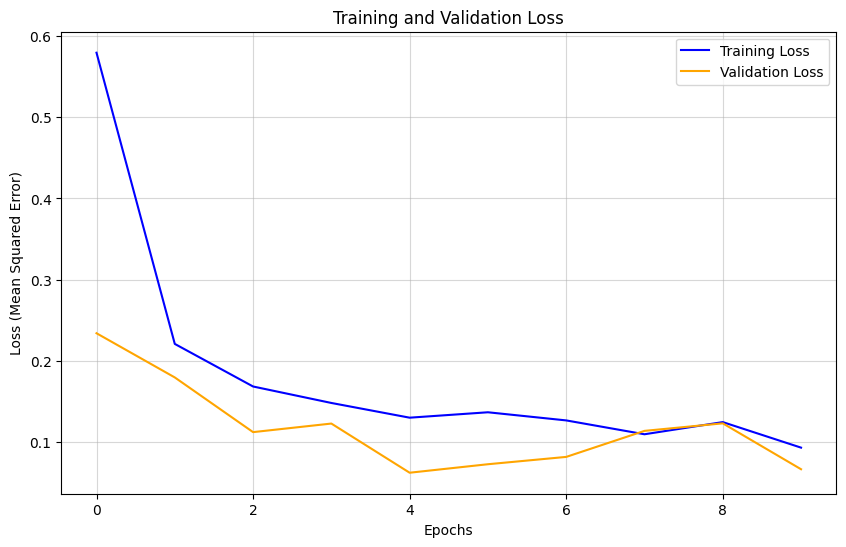

In [25]:
# Plot to visualize training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

The graph Training vs Validation loss shows that the both losses decrease steadily in the initial epochs, indicating effective learning. However, in later epochs, the validation loss begins to stabilize and slightly increase at some points, which may suggest the onset of overfitting. The model effectively minimizes error but highlights the importance of regularization techniques and stopping criteria, like early stopping, to maintain generalization on unseen data.

### Predictions, evaluation, and metrics

13682/13682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step


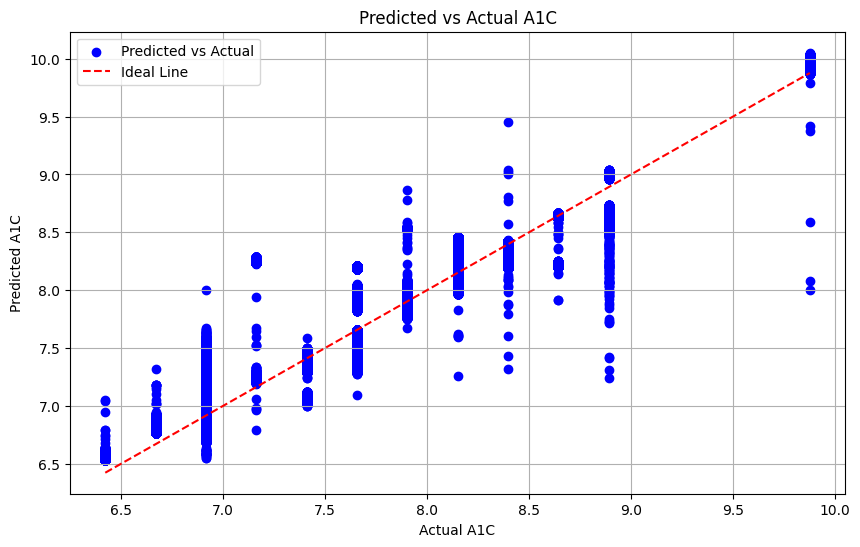

Mean Squared Error: 0.0623
Mean Absolute Error: 0.1731
R2 Score: 0.9332


In [26]:
# Predictions and evaluation
y_pred = model.predict(X_val)

# Plot to see actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, label="Predicted vs Actual", color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Ideal Line")
plt.title("Predicted vs Actual A1C")
plt.xlabel("Actual A1C")
plt.ylabel("Predicted A1C")
plt.legend()
plt.grid()
plt.show()

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

This scatter plot shows the predicted A1C values vs actual A1C values for the test dataset. While many predictions align well with the ideal line, the dispersion around higher A1C values suggests variability in the model's predictive accuracy. This could be partially attributed to the low quantity of subjects in the dataset, which may limit the model's ability to generalize across a broader range of A1C values.

## Model Performance Metrics Results:

The performance metrics indicate that there is a strong predictive accuracy in the model:

- **Mean Squared Error (MSE): 0.0623**: Shows minimal average squared deviation between predicted and actual A1C values.
- **Mean Absolute Error (MAE): 0.1731**: We can say that on average, predictions deviate by just 0.17 A1C points from the actual values, showcasing good precision.
- **R² Score: 0.9332**: This high value (very close to 1) indicates that the model explains 93.32% of the variance in the A1C values, demonstrating strong fit to the data.

*However, the limited number of subjects in the dataset may limit generalization to unseen data.*